# Laboratory Exercise: Bank Marketing Campaign Outcome Prediction

## Introduction

In this laboratory exercise, you will build a **binary classification model** that predicts whether a client will **subscribe to a term deposit** as a result of a **direct marketing campaign** conducted by a Portuguese banking institution.

Each data sample represents information about a single client and their interaction with a marketing campaign (mainly phone calls). The goal is to predict the final campaign outcome based on **demographic**, **financial**, and **campaign-related** features.

You will implement a **complete machine learning pipeline using PyTorch**, including data preprocessing, dataset definition, model design, training, evaluation, visualization, and final testing.

This exercise focuses on **tabular data**, **mixed categorical and numerical features**, and **binary classification** using **Binary Cross-Entropy loss**.

---

## Problem Definition

- **Task:** Binary classification
- **Target column:** `y`
- **Target values:**
  - `yes` → client subscribed to a term deposit
  - `no` → client did not subscribe
- **Goal:** Predict whether a client will subscribe to a term deposit after the marketing campaign

You will work with a provided dataset (`dataset.csv`) derived from real-world banking marketing data.

---

## Tasks Overview

You are required to implement the following components:

### 1. Data Preparation
- Load the `dataset.csv` file
- Identify **numerical** and **categorical** features
- Encode categorical variables appropriately
- Normalize or scale numerical features if needed
- Separate features (`X`) and target (`y`)
- Split the dataset into:
  - Training set
  - Validation set
  - Test set

---

### 2. Dataset Class
- Implement a `BankMarketingDataset` class compatible with PyTorch’s `Dataset`
- Ensure:
  - Features are stored as `float32` tensors
  - Targets are stored as binary labels with shape `(N, 1)`

---

### 3. Model Building
- Implement a `build_model_#` functions that returns a neural network suitable for **binary classification**
- The models should:
  - Accept tabular input features
  - Use appropriate activation functions
  - Output a single probability value (use `sigmoid` at the output layer)

---

### 4. Training and Evaluation
- Implement the following functions:
  - `train_one_epoch`
  - `evaluate`
  - `test`
- Use:
  - `BCELoss`
- Train the model for a fixed number of epochs
- Track:
  - Training loss
  - Validation loss
  - Validation accuracy

---

### 5. Visualization
- Plot the following curves:
  - Training loss vs. epochs
  - Validation loss vs. epochs
  - Validation accuracy vs. epochs

All plots must be clearly labeled and interpretable.

---

### 6. Testing and Reporting
- Evaluate the final trained model on the **test dataset**
- Generate and display a **classification report**, including:
  - Precision
  - Recall
  - F1-score
  - Accuracy

---

## Model Comparison Requirement

You must design and train **two different model configurations**, for example:
- Different number of hidden layers
- Different number of neurons per layer
- Different activation functions
- Use of dropout or other regularization techniques

For **each model**, you must:
- Train it for the same number of epochs
- Plot training and validation metrics
- Evaluate it on the test dataset
- Compare the results and briefly discuss which model performs better and why

## Dataset Description

Each row in the dataset corresponds to one client contact and includes the following feature groups:

### Client Information
- `age` – age of the client (numeric)
- `job` – type of job (categorical)
- `marital` – marital status (categorical)
- `education` – education level (categorical)
- `default` – has credit in default? (yes/no)

### Financial Information
- `balance` – average yearly balance (numeric)
- `housing` – has housing loan? (yes/no)
- `loan` – has personal loan? (yes/no)

### Campaign Contact Information
- `contact` – communication type (categorical)
- `day` – last contact day of the month (numeric)
- `month` – last contact month (categorical)
- `duration` – last contact duration in seconds (numeric)

### Campaign History
- `campaign` – number of contacts performed during this campaign
- `pdays` – number of days since the client was last contacted
- `previous` – number of contacts before this campaign
- `poutcome` – outcome of the previous marketing campaign (categorical)

### Target Variable
- `y` – whether the client subscribed to a term deposit (`yes` / `no`)

In [112]:
from typing import Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [113]:
def transform(data: str) -> int:
    return 1 if data == "yes" else 0


def prepare_data(
    df: pd.DataFrame,
) -> Tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    ColumnTransformer,
]:
    """
    Prepare the bank marketing dataset for training and evaluation.

    The input DataFrame contains demographic, financial, and campaign-related
    information about clients contacted during a direct marketing campaign.
    The target column `y` indicates whether the client subscribed to a term
    deposit (`yes` or `no`).

    Steps (you MUST follow these steps):
    1. Identify feature columns and the target column `y`.
    2. Separate features (X) and target (y).
    3. Encode the target labels:
       - `yes` → 1
       - `no` → 0
    4. Identify categorical and numerical feature columns.
    5. Use ColumnTransformer with OneHotEncoder to encode all categorical columns:
       - use OneHotEncoder(drop="first", sparse_output=False)
       - Pass numerical features without modification
    6. Fit the preprocessor on the training data.
    7. Split the data in TWO stages (keep stratification):
       - First split into train and test:
            * test_size = 0.2
            * random_state = 42
            * stratify = y
       - Then split the training part into train and validation:
            * test_size = 0.2   (20% of the training set)
            * random_state = 42
            * stratify = y_train
    8. Return:
         X_train, X_val, X_test, y_train, y_val, y_test, preprocessor

    Notes:
    - The returned X arrays must be fully numeric.
    - The returned y arrays must contain binary labels with shape (N, 1) or (N,).
    - The data must be suitable for PyTorch binary classification.
    """

    X = df.drop(columns=["y"])
    y = df["y"].map({"yes": 1, "no": 0}).values.reshape(-1, 1)
    # y = df["y"].apply(transform) # alternativna opcija

    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X.select_dtypes(include=["int", "float"]).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_cols)
        ],
        remainder="passthrough",
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train,
    )

    X_train = preprocessor.fit_transform(X_train)
    X_val = preprocessor.transform(X_val)
    X_test = preprocessor.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, preprocessor


In [114]:
class BankMarketingDataset(Dataset):
    """
    A PyTorch Dataset for bank marketing binary classification.

    Each sample consists of:
    - a numeric feature vector representing a client's profile and campaign data
    - a binary label indicating whether the client subscribed to a term deposit

    Requirements:
    - __init__(self, X, y):
        * X: numpy array of numeric features
        * y: array-like of binary labels (0 or 1)
        * Store:
            - X as a float32 tensor
            - y as a float32 tensor with shape (N, 1)
    - __len__(self):
        * Return the number of samples
    - __getitem__(self, idx):
        * Return (X[idx], y[idx])
    """

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        # self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1) # alternativna opcija

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])


In [115]:
def train_one_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion,
    optimizer,
) -> float:
    """
    Train the model for ONE epoch on the training dataset.

    This is a binary classification task for predicting whether a client
    subscribes to a term deposit.

    Requirements:
    - Set the model to training mode using model.train()
    - Iterate over batches from train_loader
    - For each batch:
        * Compute model outputs (logits or probabilities)
        * Compute the loss using Binary Cross-Entropy loss
          (BCELoss or BCEWithLogitsLoss)
        * Zero the gradients
        * Perform backpropagation
        * Update model parameters using the optimizer
    - Accumulate the training loss over all batches
    - Return the average training loss as a float
      (total loss divided by the number of batches)
    """

    model.train()
    losses = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses / len(train_loader)


In [116]:
def evaluate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
) -> Tuple[float, float]:
    """
    Evaluate the model on the validation dataset.

    This is a binary classification task for bank marketing outcome prediction.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from val_loader
    - For each batch:
        * Compute model outputs
        * Compute and accumulate validation loss
        * Convert outputs to predicted labels using threshold 0.5
        * Collect predicted labels and true labels
    - Compute validation accuracy over the entire validation set
    - Return:
        - validation accuracy (float)
        - validation loss (float)
    """

    model.eval()
    losses = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (
        correct / total,
        losses / len(val_loader),
    )

In [117]:
def test(
    model: nn.Module,
    test_loader: DataLoader,
) -> tuple[Tensor, Tensor]:
    """
    Evaluate the trained model on the test dataset.

    This function performs inference for binary classification of
    bank marketing campaign outcomes.

    Requirements:
    - Set the model to evaluation mode using model.eval()
    - Disable gradient computation using torch.no_grad()
    - Iterate over batches from test_loader
    - For each batch:
        * Compute model outputs
        * Convert outputs to predicted labels using threshold 0.5
        * Collect all predicted labels and true labels
    - Return:
        - Tensor of true labels (shape: N,)
        - Tensor of predicted labels (shape: N,)

    These outputs will be used to compute a classification report.
    """

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    return (
        torch.tensor(all_labels),
        torch.tensor(all_preds),
    )

In [118]:
def build_model_1(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for bank marketing
    binary classification.

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final layer must output a single value
    - Do NOT apply Sigmoid if using BCEWithLogitsLoss

    Note:
    - Use Binary Cross-Entropy loss during training
    - This model will serve as the baseline architecture
    """

    return nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid(),
    )

In [119]:
def build_model_2(input_dim: int) -> nn.Module:
    """
    Build and return a second PyTorch neural network for bank marketing
    binary classification.

    This model should differ from build_model_1
    (e.g. more layers, more neurons, dropout, different activations).

    Requirements:
    - Use nn.Sequential to define the model
    - The model must accept input vectors of size input_dim
    - The final layer must output a single value
    - Do NOT apply Sigmoid if using BCEWithLogitsLoss

    Note:
    - Use Binary Cross-Entropy loss during training
    - This model will be compared against build_model_1
    """

    return nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Dropout(0.33),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid(),
    )

### Build the models

In [120]:
df = pd.read_csv("./dataset.csv")
X_train, X_val, X_test, y_train, y_val, y_test, preprocessor = prepare_data(df)

train_loader = DataLoader(
    BankMarketingDataset(X_train, y_train),
    batch_size=64,
)
val_loader = DataLoader(
    BankMarketingDataset(X_val, y_val),
    batch_size=64,
)
test_loader = DataLoader(
    BankMarketingDataset(X_test, y_test),
    batch_size=64,
)

input_dim = X_train.shape[1]
model_1 = build_model_1(input_dim)
model_2 = build_model_2(input_dim)

criterion_1 = nn.BCELoss()
criterion_2 = nn.BCELoss()

optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)

### Train model 1

In [121]:
epochs = 25
train_losses_1 = []
val_losses_1 = []
val_accuracies_1 = []

for epoch in range(epochs):
    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss = train_one_epoch(
        model_1,
        train_loader,
        criterion_1,
        optimizer_1,
    )
    val_acc, val_loss = evaluate(
        model_1,
        val_loader,
        criterion_1,
    )

    train_losses_1.append(train_loss)
    val_losses_1.append(val_loss)
    val_accuracies_1.append(val_acc)

    print(
        f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}"
    )

Epoch 1/25 | Train loss: 0.6472 | Val acc: 0.8168
Epoch 2/25 | Train loss: 0.5241 | Val acc: 0.8685
Epoch 3/25 | Train loss: 0.3916 | Val acc: 0.8427
Epoch 4/25 | Train loss: 0.4364 | Val acc: 0.8293
Epoch 5/25 | Train loss: 0.4114 | Val acc: 0.8271
Epoch 6/25 | Train loss: 0.3844 | Val acc: 0.8600
Epoch 7/25 | Train loss: 0.3699 | Val acc: 0.8507
Epoch 8/25 | Train loss: 0.3535 | Val acc: 0.8662
Epoch 9/25 | Train loss: 0.4675 | Val acc: 0.8634
Epoch 10/25 | Train loss: 0.3641 | Val acc: 0.8857
Epoch 11/25 | Train loss: 0.3605 | Val acc: 0.8622
Epoch 12/25 | Train loss: 0.3660 | Val acc: 0.8626
Epoch 13/25 | Train loss: 0.3748 | Val acc: 0.8343
Epoch 14/25 | Train loss: 0.4327 | Val acc: 0.8790
Epoch 15/25 | Train loss: 0.4228 | Val acc: 0.8976
Epoch 16/25 | Train loss: 0.4007 | Val acc: 0.8886
Epoch 17/25 | Train loss: 0.3566 | Val acc: 0.8898
Epoch 18/25 | Train loss: 0.3862 | Val acc: 0.9006
Epoch 19/25 | Train loss: 0.3610 | Val acc: 0.8944
Epoch 20/25 | Train loss: 0.3473 | Val a

### Train model 2

In [122]:
epochs = 25
train_losses_2 = []
val_losses_2 = []
val_accuracies_2 = []

for epoch in range(epochs):
    # Call all required functions and store the computed metrics
    # (training loss, validation loss, and validation accuracy).

    train_loss = train_one_epoch(
        model_2,
        train_loader,
        criterion_2,
        optimizer_2,
    )
    val_acc, val_loss = evaluate(
        model_2,
        val_loader,
        criterion_2,
    )

    train_losses_2.append(train_loss)
    val_losses_2.append(val_loss)
    val_accuracies_2.append(val_acc)

    print(
        f"Epoch {epoch + 1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}"
    )

Epoch 1/25 | Train loss: 1.3555 | Val acc: 0.8853
Epoch 2/25 | Train loss: 0.3629 | Val acc: 0.8844
Epoch 3/25 | Train loss: 0.3166 | Val acc: 0.8860
Epoch 4/25 | Train loss: 0.3011 | Val acc: 0.8904
Epoch 5/25 | Train loss: 0.2932 | Val acc: 0.8864
Epoch 6/25 | Train loss: 0.2871 | Val acc: 0.8844
Epoch 7/25 | Train loss: 0.2839 | Val acc: 0.8857
Epoch 8/25 | Train loss: 0.2798 | Val acc: 0.8851
Epoch 9/25 | Train loss: 0.2789 | Val acc: 0.8853
Epoch 10/25 | Train loss: 0.2737 | Val acc: 0.8879
Epoch 11/25 | Train loss: 0.2720 | Val acc: 0.8876
Epoch 12/25 | Train loss: 0.2732 | Val acc: 0.8835
Epoch 13/25 | Train loss: 0.2662 | Val acc: 0.8866
Epoch 14/25 | Train loss: 0.2616 | Val acc: 0.8853
Epoch 15/25 | Train loss: 0.2609 | Val acc: 0.8847
Epoch 16/25 | Train loss: 0.2591 | Val acc: 0.8891
Epoch 17/25 | Train loss: 0.2600 | Val acc: 0.8853
Epoch 18/25 | Train loss: 0.2598 | Val acc: 0.8890
Epoch 19/25 | Train loss: 0.2554 | Val acc: 0.8898
Epoch 20/25 | Train loss: 0.2563 | Val a

### Visualize

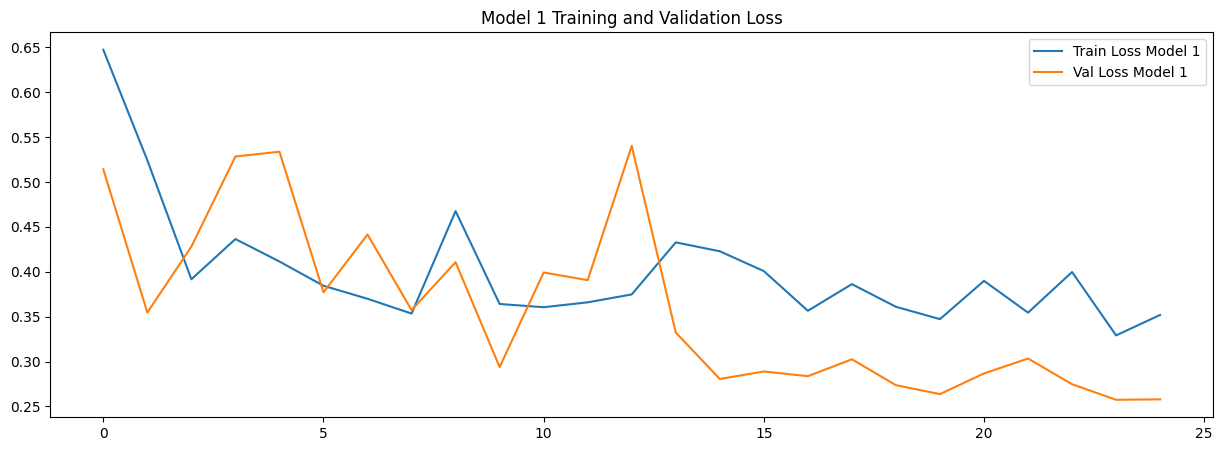

In [123]:
plt.figure(figsize=(15, 5))

plt.plot(train_losses_1, label="Train Loss Model 1")
plt.plot(val_losses_1, label="Val Loss Model 1")
plt.title("Model 1 Training and Validation Loss")
plt.legend()

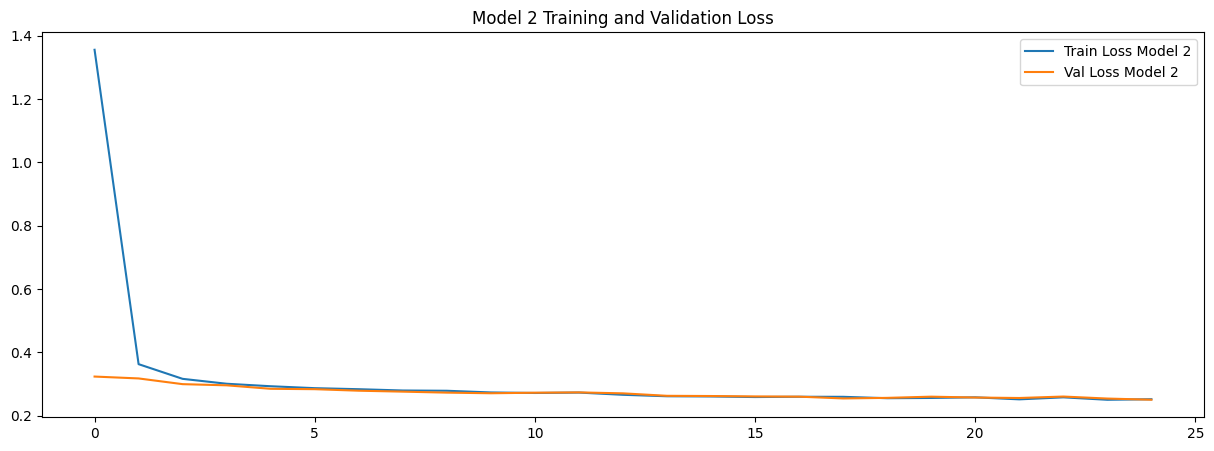

In [124]:
plt.figure(figsize=(15, 5))

plt.plot(train_losses_2, label="Train Loss Model 2")
plt.plot(val_losses_2, label="Val Loss Model 2")
plt.title("Model 2 Training and Validation Loss")
plt.legend()

### Evaluate

In [125]:
y_true_1, y_pred_1 = test(model_1, test_loader)

print(classification_report(y_true_1, y_pred_1))

y_true_2, y_pred_2 = test(model_2, test_loader)

print(classification_report(y_true_2, y_pred_2))

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      7985
         1.0       0.58      0.46      0.51      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.71      0.73      9043
weighted avg       0.89      0.90      0.89      9043

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      7985
         1.0       0.67      0.12      0.21      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.56      0.57      9043
weighted avg       0.87      0.89      0.86      9043

